In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os 
from tabulate import tabulate
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import ResidualsPlot

In [2]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [3]:
# edit to your personal path to connect to the file
os.chdir(r"C:\Users\dboyd\OneDrive\Documents\MSBA\Q3\CSA")

In [4]:
# reading in the data from a simple csv from Kaggle
data = pd.read_csv('beer_reviews.csv')
print(data.head())

   brewery_id             brewery_name  review_time  review_overall  \
0       10325          Vecchio Birraio   1234817823             1.5   
1       10325          Vecchio Birraio   1235915097             3.0   
2       10325          Vecchio Birraio   1235916604             3.0   
3       10325          Vecchio Birraio   1234725145             3.0   
4        1075  Caldera Brewing Company   1293735206             4.0   

   review_aroma  review_appearance review_profilename  \
0           2.0                2.5            stcules   
1           2.5                3.0            stcules   
2           2.5                3.0            stcules   
3           3.0                3.5            stcules   
4           4.5                4.0     johnmichaelsen   

                       beer_style  review_palate  review_taste  \
0                      Hefeweizen            1.5           1.5   
1              English Strong Ale            3.0           3.0   
2          Foreign / Export Stou

In [64]:
# converting review time to be datetime 
data['review_time'] = pd.to_datetime(data['review_time'], unit = 's')
print(data.review_time.head())

0   2009-02-16 20:57:03
1   2009-03-01 13:44:57
2   2009-03-01 14:10:04
3   2009-02-15 19:12:25
4   2010-12-30 18:53:26
Name: review_time, dtype: datetime64[ns]


In [65]:
# seeing how many unique beers & breweries & styles
find_unique = ['brewery_id','brewery_name','beer_beerid','beer_name','beer_style']
for cname in find_unique:
    print(cname, data[cname].nunique())

brewery_id 5840
brewery_name 5742
beer_beerid 66055
beer_name 56857
beer_style 104


In [66]:
# simple descriptive statistics 
# notice the perfect roundness of many of the quartiles, seems to good to be realistic data
# we have yet to aggregate the data by any single variable
print(data.describe())

         brewery_id  review_overall  review_aroma  review_appearance  \
count  1.586614e+06    1.586614e+06  1.586614e+06       1.586614e+06   
mean   3.130099e+03    3.815581e+00  3.735636e+00       3.841642e+00   
std    5.578104e+03    7.206219e-01  6.976167e-01       6.160928e-01   
min    1.000000e+00    0.000000e+00  1.000000e+00       0.000000e+00   
25%    1.430000e+02    3.500000e+00  3.500000e+00       3.500000e+00   
50%    4.290000e+02    4.000000e+00  4.000000e+00       4.000000e+00   
75%    2.372000e+03    4.500000e+00  4.000000e+00       4.000000e+00   
max    2.800300e+04    5.000000e+00  5.000000e+00       5.000000e+00   

       review_palate  review_taste      beer_abv   beer_beerid  
count   1.586614e+06  1.586614e+06  1.518829e+06  1.586614e+06  
mean    3.743701e+00  3.792860e+00  7.042387e+00  2.171279e+04  
std     6.822184e-01  7.319696e-01  2.322526e+00  2.181834e+04  
min     1.000000e+00  1.000000e+00  1.000000e-02  3.000000e+00  
25%     3.500000e+00  3.50

In [67]:
# checking for duplicates, we don't want to double count reviews
print(data.duplicated().sum())

0


In [68]:
# we inspect the data to see if nulls exist and we see that there are nulls that need to be handled 
# we could work to inpute the values, but with a large dataset like we have & the scope of our analysis, we can just drop them
print(data.info())
data.dropna(inplace = True)
data.drop_duplicates(inplace = True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null datetime64[ns]
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 157.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518478 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1518478 non-null int64
brewery_name          1518478 n

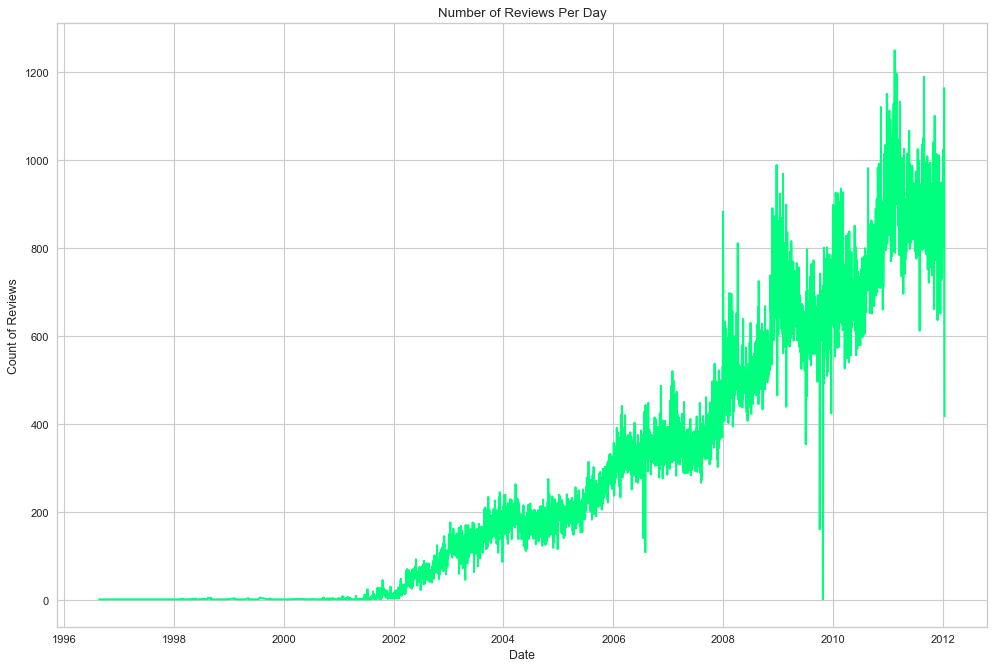

In [69]:
# we want to understand when the bulk of our data was produced
# for this we will look at review time and use the ability of datetimes to be parsed 
grouped_data = data[['review_time']].groupby(data['review_time'].dt.date).agg(['count'])
fig=plt.figure(figsize=(15,10), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(grouped_data, color = 'springgreen')
plt.title('Number of Reviews Per Day')
plt.xlabel('Date')
plt.ylabel('Count of Reviews')
plt.show()

In [70]:
# the key to this analysis is in aggregating the beer reviews by beer, brewery, abv and style 
# this allows us to find the average scores by each beer in each of the categories and overall
beers = data.groupby(['brewery_name','beer_name', 'beer_style' ,'beer_abv'])\
.agg({'review_overall':'mean',
      'review_aroma':'mean',
      'review_appearance':'mean',
      'review_palate':'mean',
      'review_taste':'mean'
      ,'review_profilename':'count'})\
.rename(columns = {'review_profilename':'review_count'}).reset_index()
# going to filter for beers that have mroe than one review because we want to have a minimum of two opinions to score each beer
beers = beers[beers['review_count'] >= 2]
print(beers.info())
print(beers.head())
print(beers.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33324 entries, 1 to 48878
Data columns (total 10 columns):
brewery_name         33324 non-null object
beer_name            33324 non-null object
beer_style           33324 non-null object
beer_abv             33324 non-null float64
review_overall       33324 non-null float64
review_aroma         33324 non-null float64
review_appearance    33324 non-null float64
review_palate        33324 non-null float64
review_taste         33324 non-null float64
review_count         33324 non-null int64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.8+ MB
None
            brewery_name         beer_name        beer_style  beer_abv  \
1      't Hofbrouwerijke        Bosprotter            Tripel       8.5   
2      't Hofbrouwerijke  Hof Korvatunturi           Old Ale      11.0   
3      't Hofbrouwerijke          Hofblues  Belgian Dark Ale       5.5   
4      't Hofbrouwerijke          Hofdraak  Belgian Dark Ale       6.5   
7  (512) Brewing Co

In [71]:
# we can export this dataframe to a csv or other file type to then visualize the data in another program like tableau
beers.to_csv('beers.csv')

In [72]:
# this was more of a whimsy type deal but we wanted to see the highest ABV
# I'm pretty sure anyone would be floored by one of these beers... what is BrewDog trying to do?
ABV = beers[['brewery_name','beer_name','beer_abv']].sort_values(by = ['beer_abv'],ascending = False)
print(ABV.head(3).reset_index(drop = True))

   brewery_name                      beer_name  beer_abv
0  Schorschbräu  Schorschbräu Schorschbock 43%     43.00
1       BrewDog             Sink The Bismarck!     41.00
2  Schorschbräu  Schorschbräu Schorschbock 40%     39.44


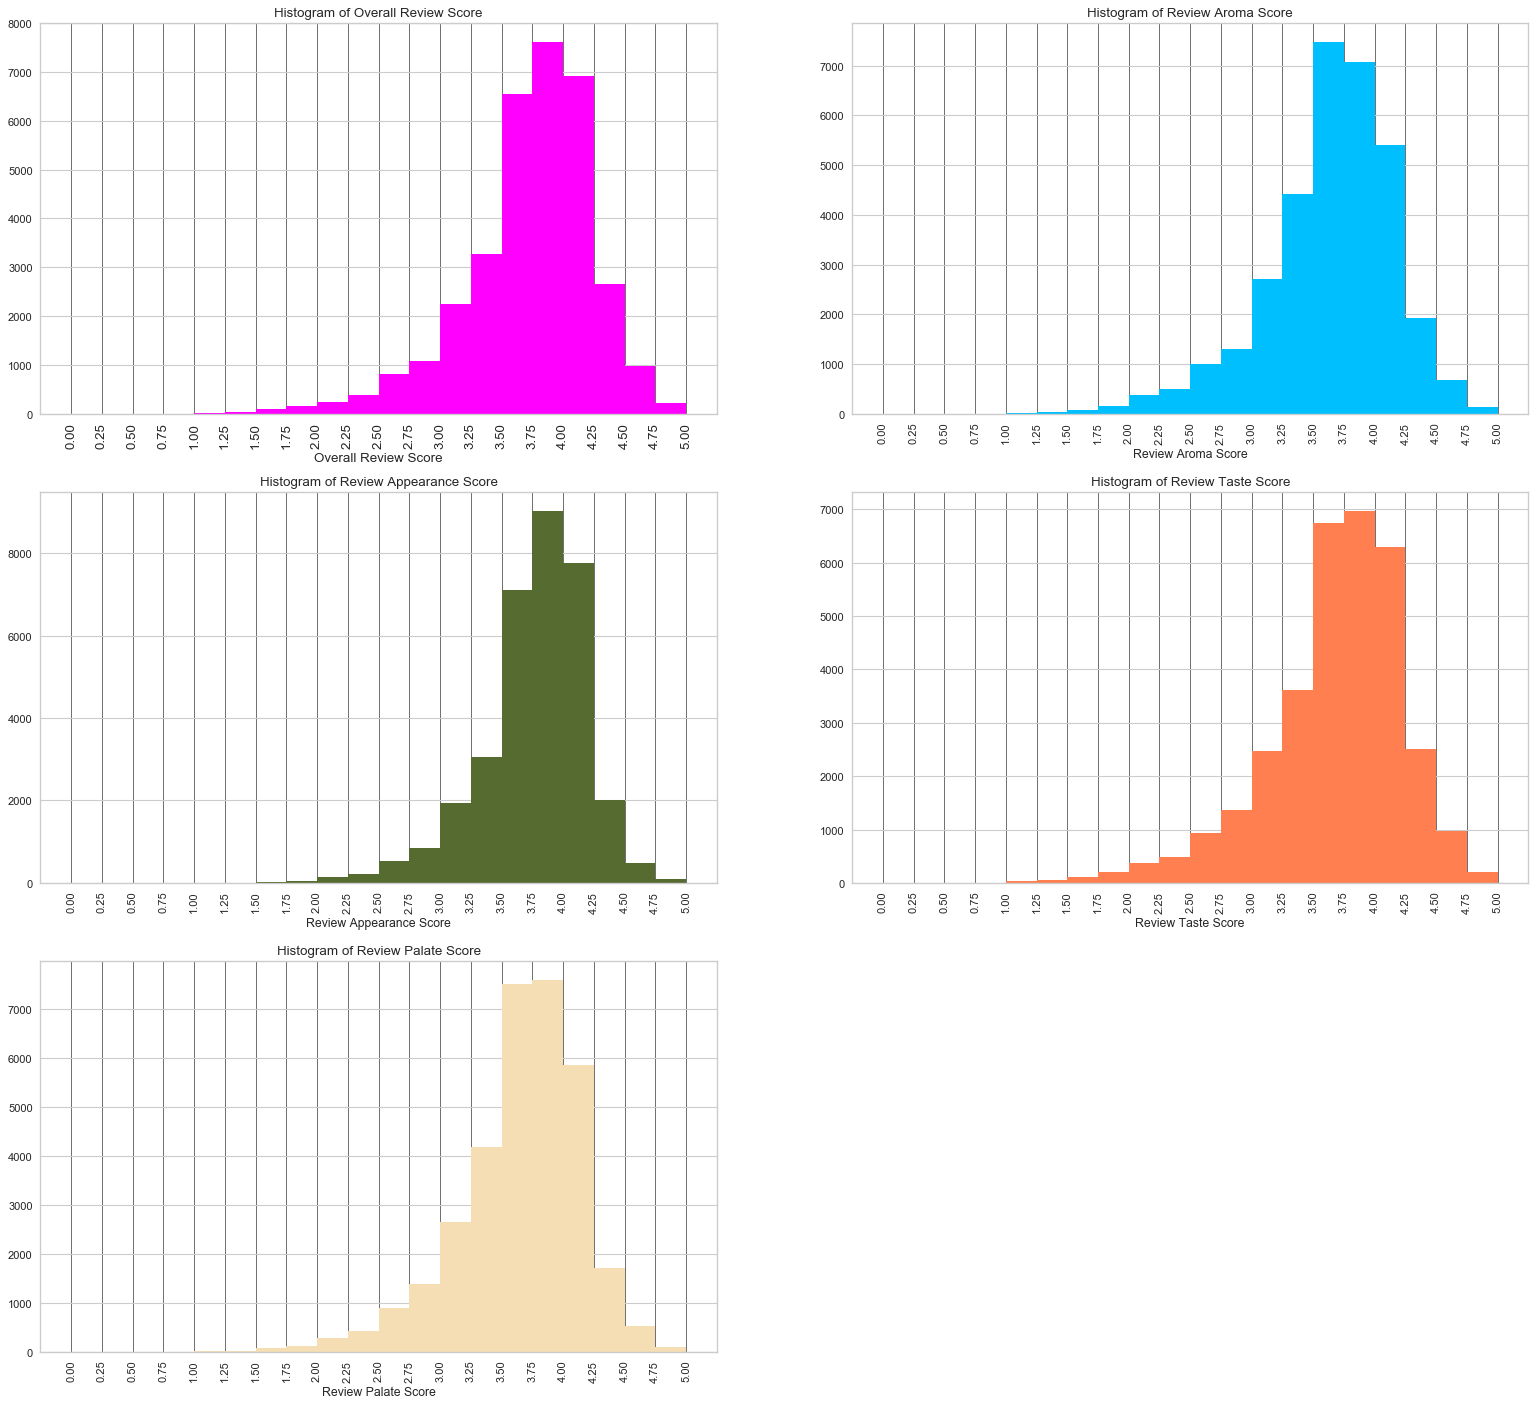

In [73]:
# histogram of the different review scores
fig=plt.figure(figsize=(24,22), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(3,2,1)
plt.hist(beers.review_overall, color = 'fuchsia', bins = 20, range = (0,5))
plt.xticks(np.arange(0,5.25,.25).tolist(), rotation = 90, fontsize = 12)
plt.grid(axis = 'x',color = 'black', linestyle ='-', linewidth = .5)
plt.title('Histogram of Overall Review Score')
plt.xlabel('Overall Review Score', fontsize = 12)
plt.subplot(3,2,2)
plt.hist(beers.review_aroma, color = 'deepskyblue', bins = 20, range = (0,5))
plt.xticks(np.arange(0,5.25,.25).tolist(), rotation = 90)
plt.grid(axis = 'x',color = 'black', linestyle ='-', linewidth = .5)
plt.title('Histogram of Review Aroma Score')
plt.xlabel('Review Aroma Score')
plt.subplot(3,2,3)
plt.hist(beers.review_appearance, color = 'darkolivegreen', bins = 20, range = (0,5))
plt.xticks(np.arange(0,5.25,.25).tolist(), rotation = 90)
plt.grid(axis = 'x',color = 'black', linestyle ='-', linewidth = .5)
plt.title('Histogram of Review Appearance Score')
plt.xlabel('Review Appearance Score')
plt.subplot(3,2,4)
plt.hist(beers.review_taste, color = 'coral', bins = 20, range = (0,5))
plt.xticks(np.arange(0,5.25,.25).tolist(), rotation = 90)
plt.grid(axis = 'x',color = 'black', linestyle ='-', linewidth = .5)
plt.title('Histogram of Review Taste Score')
plt.xlabel('Review Taste Score')
plt.subplot(3,2,5)
plt.hist(beers.review_palate, color = 'wheat',  bins = 20, range = (0,5))
plt.xticks(np.arange(0,5.25,.25).tolist(), rotation = 90)
plt.grid(axis = 'x',color = 'black', linestyle ='-', linewidth = .5)
plt.title('Histogram of Review Palate Score')
plt.xlabel('Review Palate Score')
plt.show()

In [74]:
# looking at how many reviews each Profile has reviewed
profilereviews = data['review_profilename'].value_counts()
print(profilereviews.head(10).sort_values(ascending = False))

northyorksammy    5346
mikesgroove       4283
BuckeyeNation     4246
Thorpe429         3273
brentk56          3186
womencantsail     3163
ChainGangGuy      3151
Phyl21ca          3138
NeroFiddled       3098
oberon            2899
Name: review_profilename, dtype: int64


In [75]:
# grouping just the beer data, nothing to do with reviews 
# then we are looking at some of the most common styles, beers, and breweries in this dataset
beer_grouping = data[['brewery_name','beer_name','beer_style','beer_abv']].drop_duplicates()
print(tabulate(beer_grouping.head(), headers = 'keys', tablefmt='psql'))
print('Top Beer Styles:\n',beer_grouping['beer_style'].value_counts().head(10))
print('Top Breweries:\n',beer_grouping['brewery_name'].value_counts().head(10))
print('Top Beers:\n',beer_grouping['beer_name'].value_counts().head(10))

+----+-------------------------+------------------------+--------------------------------+------------+
|    | brewery_name            | beer_name              | beer_style                     |   beer_abv |
|----+-------------------------+------------------------+--------------------------------+------------|
|  0 | Vecchio Birraio         | Sausa Weizen           | Hefeweizen                     |        5   |
|  1 | Vecchio Birraio         | Red Moon               | English Strong Ale             |        6.2 |
|  2 | Vecchio Birraio         | Black Horse Black Beer | Foreign / Export Stout         |        6.5 |
|  3 | Vecchio Birraio         | Sausa Pils             | German Pilsener                |        5   |
|  4 | Caldera Brewing Company | Cauldron DIPA          | American Double / Imperial IPA |        7.7 |
+----+-------------------------+------------------------+--------------------------------+------------+
Top Beer Styles:
 American IPA                      2494
America

In [76]:
# calculating new variable - average from four scores (aroma, appearance, taste, palate)
# how might the average of the four attribute scores compare to the overall review score?
beers['average_among_attributes'] = (beers['review_aroma']+beers['review_appearance']+beers\
                                     ['review_taste']+beers['review_palate'])/4
print(beers[['beer_name','average_among_attributes']].sort_values('average_among_attributes', ascending = False)\
      .reset_index(drop = True).head(10))

                                          beer_name  average_among_attributes
0                            Love Child Belgiweizen                  4.875000
1  Lips Of Faith - Eric's Ale (Bourbon Barrel Aged)                  4.875000
2    Alesmith Speedway Stout - Vanilla And Coconut                   4.875000
3                         Imperial Mocha Java Stout                  4.875000
4                  Black Damnation XI - Special Kay                  4.843750
5                                          El Gordo                  4.821429
6                    Chocolate Cinnamon Cream Stout                  4.812500
7                        Cascade Straight Bourbonic                  4.812500
8                         Bourbon Legend Barleywine                  4.812500
9                                      Coffee Stout                  4.750000


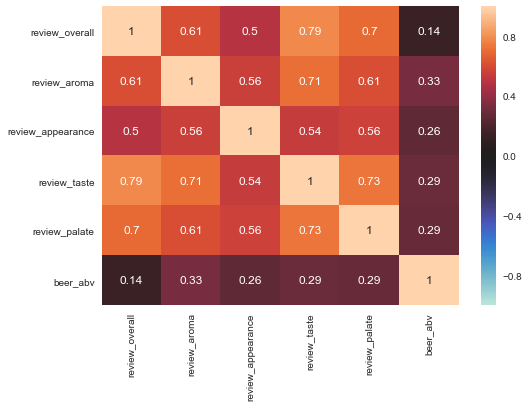

In [77]:
# heatmap before grouping (using almost categorical values - .5,1.1.5,2,...)
sns.heatmap(data[['review_overall','review_aroma','review_appearance','review_taste','review_palate','beer_abv']]\
            .corr(method = 'pearson'),\
             center = 0, vmin = -1, vmax = 1, annot = True)
plt.show()

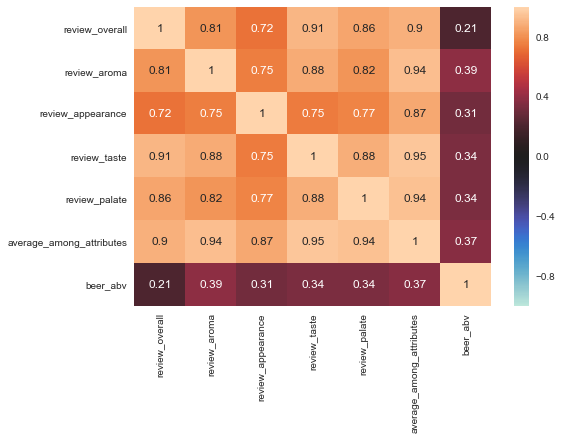

In [78]:
# heatmap after grouping (uses more continuous values - calculated from means during aggreagation of rows)
sns.heatmap(beers[['review_overall','review_aroma','review_appearance','review_taste','review_palate','average_among_attributes','beer_abv']]\
            .corr(method= 'pearson'),\
             center = 0, vmin = -1, vmax = 1, annot = True)
plt.show()

In [79]:
# data is ready to be used in model
#print(beers.head())
target = np.array(beers['review_overall']).reshape(-1,1)
predictors = beers[['review_palate','review_taste','review_appearance','review_aroma', 'average_among_attributes']]

In [80]:
# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 42, test_size = .3)

In [81]:
#training & evalutaing the model 
model = LinearRegression(normalize = True)
model.fit(X_train, y_train)
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
train_mse = MSE(y_train, train_prediction)
test_mse = MSE(y_test, test_prediction)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
score = model.score(X_test, y_test)
print(model.coef_, model.intercept_)
print('Training RMSE:', train_rmse)
print('Test RMSE:',test_rmse)
print('Model Score - R^2:',score)

[[-1.00716935e+12 -1.00716935e+12 -1.00716935e+12 -1.00716935e+12
   4.02867739e+12]] [0.29104956]
Training RMSE: 0.2057721930322603
Test RMSE: 0.2102913916682297
Model Score - R^2: 0.8396884517172668


[0.05880021 0.45285477 0.         0.         0.11460122]


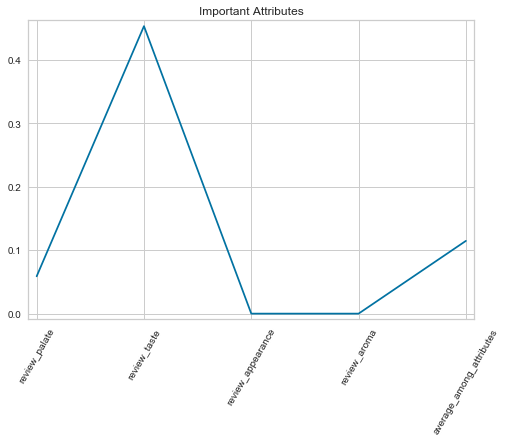

In [82]:
# Lasso regression to determine which variable is the most important when it comes to prdicting overall review score
lasso = Lasso(alpha =.001, normalize = True)
lasso.fit(X_train, y_train)
print(lasso.coef_)
plt.figure()
plt.plot(range(len(predictors.columns)), lasso.coef_)
plt.xticks(range(len(predictors.columns)), predictors.columns.values, rotation=60)
plt.margins(0.02)
plt.title('Important Attributes')
plt.show()

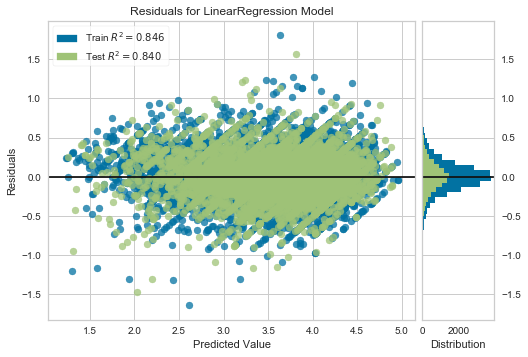

In [83]:
model = LinearRegression(normalize = True)
visualization = ResidualsPlot(model)
visualization.fit(X_train, y_train)
visualization.score(X_test, y_test)
visualization.show()

Looking at the coefficients, we see that all of them are negative except for 'avergae_among_attributes'. This does not make sense with our knowledge that there is a positive correlation between all the variables and our target variable... we will re-run it without the inclusion of 'average_among_attributes'

In [84]:
# data is ready to be used in model
#print(beers.head())
target = np.array(beers['review_overall']).reshape(-1,1)
predictors = beers[['review_palate','review_taste','review_appearance','review_aroma']]

In [85]:
# splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 42, test_size = .3)

In [86]:
# training & evalutaing the model 
model = LinearRegression(normalize = True)
model.fit(X_train, y_train)
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
train_mse = MSE(y_train, train_prediction)
test_mse = MSE(y_test, test_prediction)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
score = model.score(X_test, y_test)
print(model.coef_, model.intercept_)
print('Training RMSE:', train_rmse)
print('Test RMSE:',test_rmse)
print('Model Score - R^2:',score)

[[0.2537445  0.63963814 0.03055121 0.01143033]] [0.28676191]
Training RMSE: 0.20577210880969596
Test RMSE: 0.21027459012622526
Model Score - R^2: 0.8397140673508033


[0.10590283 0.50723438 0.         0.        ]


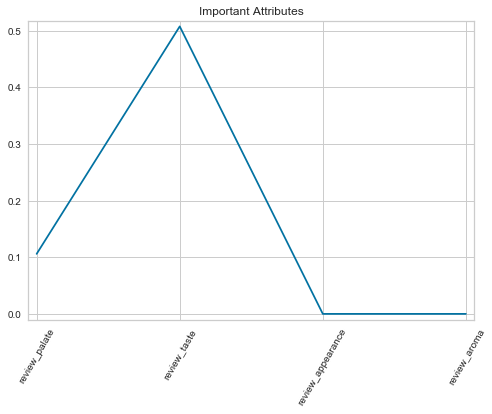

In [87]:
# Lasso regression to determine which variable is the most important when it comes to predicting overall review score
lasso = Lasso(alpha =.001, normalize = True)
lasso.fit(X_train, y_train)
print(lasso.coef_)
plt.figure()
plt.plot(range(len(predictors.columns)), lasso.coef_)
plt.xticks(range(len(predictors.columns)), predictors.columns.values, rotation=60)
plt.margins(0.02)
plt.title('Important Attributes')
plt.show()

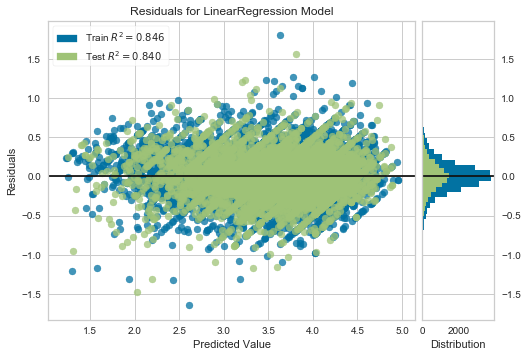

In [88]:
model = LinearRegression(normalize = True)
visualization = ResidualsPlot(model)
visualization.fit(X_train, y_train)
visualization.score(X_test, y_test)
visualization.show()

This second model has what we are looking for. Positive coefficients make logical sense with the positive correlations that exist among the variables. The model has solid RMSE values and a good R^2 value. We see that review_taste and review_palate are the most influential attributes in the model (per the Lasso regression).

In [89]:
print('Final model equation:','predicted overall_score =' + str(model.intercept_[0]) + ' + ' + 'palate(' + str(model.coef_[0][0]) + ') + ' + 'taste(' + str(model.coef_[0][1]) + ') + ' + 'appearance(' + str(model.coef_[0][2]) + ') + ' + 'aroma(' +str(model.coef_[0][3]) + ')')

Final model equation: predicted overall_score =0.28676191081142655 + palate(0.25374450125646497) + taste(0.6396381357437269) + appearance(0.030551207919424873) + aroma(0.01143033147221253)
